<a href="https://colab.research.google.com/github/shnhrtkyk/JTCcode/blob/main/05_%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%82%92%E5%88%A9%E7%94%A8%E3%81%97%E3%81%9F%E3%83%86%E3%82%AD%E3%82%B9%E3%83%88%E3%81%8B%E3%82%89%E3%81%AE%E7%82%B9%E7%BE%A4%E5%90%88%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 点群の合成

## 使用する手法
point-eというテキストを入力にして、そのテキストに対応する点群を合成する手法です。
テキストを入力して、何かを合成するというと、テキストから画像を出力する手法が有名でしょうか。
現在広く使用されているテキストからの画像合成手法はStable Diffusionと呼ばれる拡散モデルに基づいた手法です。
このpoint-eは画像の合成手法を発展させて生まれた手法です。


点群の合成が可能になると、どのようなことができるでしょうか。


# 環境セットアップ

## GitHubからコード取得

In [ ]:
%cd /content

!git clone https://github.com/openai/point-e.git

# using Commits on Dec 20, 2022
%cd /content/point-e
!git checkout fc8a607c08a3ea804cc82bf1ef8628f88a3a5d2f

/content
Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), 1.56 MiB | 3.06 MiB/s, done.
/content/point-e
Note: switching to 'fc8a607c08a3ea804cc82bf1ef8628f88a3a5d2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at fc8a607 Merge pull request #5 from openai/hj/license


## ライブラリのインストール

In [ ]:
%cd /content/point-e

!pip install -e .

/content/point-e
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-w_e3l5ny/clip_85191df6888348b58d0aa9686f7482e6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-w_e3l5ny/clip_85191df6888348b58d0aa9686f7482e6
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=82cb44e25f5fc0b3f8c0f1c472cc485ed44f41d15fe0e5c15f20fbec7a014edb
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0b1c51

## ライブラリのインポート

In [ ]:
%cd /content/point-e

from PIL import Image
from tqdm.auto import tqdm
import plotly.graph_objects as go

import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("using device is", device)

# for avoiding module 'skimage' has no attribute 'measure'
import skimage.measure
skimage.measure.label

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
from point_e.util.pc_to_mesh import marching_cubes_mesh

/content/point-e
using device is cuda


# Image to PointCloud

## 学習済みモデルのセットアップ

In [ ]:
print('creating base model...')
base_name = 'base40M' # @param ["base40M", "base300M", "base1B"]
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:12<00:00, 71.9MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
# build point cloud sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

# Text to PointCloud

## 学習済みモデルのセットアップ

In [ ]:
print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
  device=device,
  models=[base_model, upsampler_model],
  diffusions=[base_diffusion, upsampler_diffusion],
  num_points=[1024, 4096 - 1024],
  aux_channels=['R', 'G', 'B'],
  guidance_scale=[3.0, 0.0],
  model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

## Inference

point-eはテキストを入力にして点群を合成する手法です。
したがって、入力するプロンプトを設定する必要があります。
以下の例では、a humanを入力しています。
このプロンプトを変更すると、違う点群が生成できます。

In [ ]:
# 入力するテキストを指定します。
prompt = 'a human'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
  samples = x

0it [00:00, ?it/s]

できた点群を確認してみましょう。

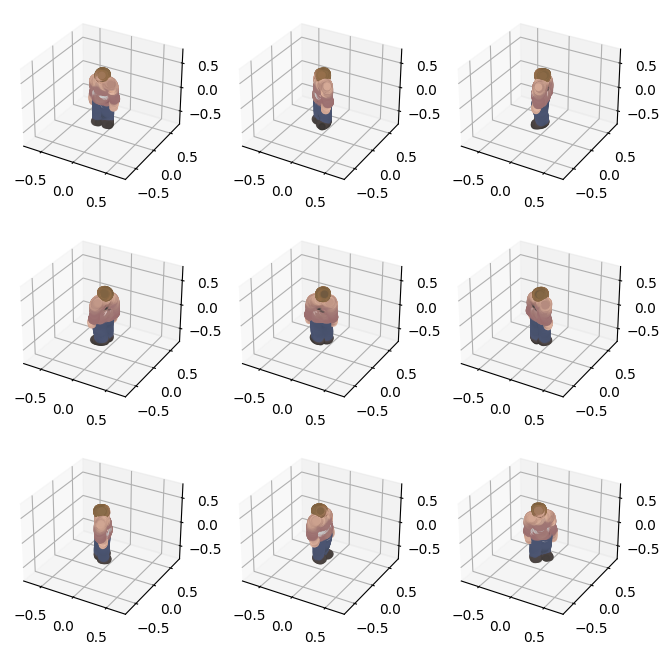

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

こちらの方法ですと、立体的に動かしながら見えます。

In [ ]:
fig_plotly = go.Figure(
  data=[
    go.Scatter3d(
      x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
      mode='markers',
      marker=dict(
        size=2,
        color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
      )
    )
  ],
  layout=dict(
    scene=dict(
      xaxis=dict(visible=False),
      yaxis=dict(visible=False),
      zaxis=dict(visible=False)
    )
  ),
)

In [ ]:
fig_plotly.show(renderer="colab")

# 新しいセクション